In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

# Add these imports at the beginning of the notebook
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

c:\Users\baoqt\miniconda3\envs\311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
import requests
import os
import zipfile

# Define paths
base_path = os.path.join(os.getcwd(), "Dataset", "Text_Generation")
os.makedirs(base_path, exist_ok=True)  # Create the folder if it doesn't exist
dataset_path = os.path.join(base_path, "cornell_movie_dialogs.zip")
extract_path = os.path.join(base_path, "cornell_movie_dialogs")

# change to True to download
DOWNLOAD_DATASET = True

if (DOWNLOAD_DATASET): 

    # URL of the Cornell Movie Dialogs Dataset
    url = "http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip"

    # Download the dataset
    print("Downloading Cornell Movie Dialogs dataset...")
    response = requests.get(url, stream=True)
    with open(dataset_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Download complete.")

    # Extract the dataset
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")

    # Clean up the zip file
    os.remove(dataset_path)
    print("Dataset is ready at:", extract_path)

Download complete.
Extracting dataset...
Extraction complete.
Dataset is ready at: c:\Users\baoqt\OneDrive\Documents\GitHub\GenAIExample\Dataset\Text_Generation\cornell_movie_dialogs


In [3]:
class SimpleTokenizer:
    def __init__(self, min_freq=2, max_vocab_size=50000):
        self.min_freq = min_freq
        self.max_vocab_size = max_vocab_size
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_freq = {}
        self.vocab_size = 2  # Starting with PAD and UNK tokens
        
    def fit(self, texts):
        # Count word frequencies
        for text in texts:
            for word in text.lower().split():
                self.word_freq[word] = self.word_freq.get(word, 0) + 1
        
        # Build vocabulary based on frequency threshold
        sorted_words = sorted(
            [(word, freq) for word, freq in self.word_freq.items() if freq >= self.min_freq],
            key=lambda x: x[1],
            reverse=True
        )
        
        # Add words to vocabulary (respecting max_vocab_size)
        for word, _ in sorted_words[:self.max_vocab_size - 2]:  # -2 for PAD and UNK
            self.word2idx[word] = self.vocab_size
            self.idx2word[self.vocab_size] = word
            self.vocab_size += 1
    
    def encode(self, texts, max_length=512, padding=True, truncation=True):
        if isinstance(texts, str):
            texts = [texts]
            
        input_ids = []
        attention_mask = []
        
        for text in texts:
            # Convert text to indices
            tokens = text.lower().split()
            if truncation:
                tokens = tokens[:max_length]
            
            ids = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]
            mask = [1] * len(ids)
            
            if padding:
                # Pad sequences to max_length
                padding_length = max_length - len(ids)
                ids = ids + [self.word2idx['<PAD>']] * padding_length
                mask = mask + [0] * padding_length
            
            input_ids.append(ids)
            attention_mask.append(mask)
        
        # Convert to tensors
        return {
            'input_ids': torch.tensor(input_ids),
            'attention_mask': torch.tensor(attention_mask)
        }
    
    def decode(self, ids):
        if isinstance(ids, torch.Tensor):
            ids = ids.tolist()
            
        if isinstance(ids[0], list):
            return [' '.join(self.idx2word.get(id, '<UNK>') for id in sequence) for sequence in ids]
        else:
            return ' '.join(self.idx2word.get(id, '<UNK>') for id in ids)
        
    def tokenize(self, text):
        """Split text into tokens (words)"""
        return text.lower().split()

In [4]:
import os
import random
import re
import numpy as np
import pandas as pd

# Load and process the data
def load_cornell_movie_dialogs(extract_path, sample_ratio=1.0, max_pairs=50000):
    movie_lines_path = os.path.join(extract_path, "cornell movie-dialogs corpus", "movie_lines.txt")
    movie_conversations_path = os.path.join(extract_path, "cornell movie-dialogs corpus", "movie_conversations.txt")
    
    # Read movie lines
    id2line = {}
    print("Loading movie lines...")
    with open(movie_lines_path, 'r', encoding='iso-8859-1') as f:
        for line in f:
            parts = line.strip().split(" +++$+++ ")
            if len(parts) == 5:
                line_id = parts[0]
                dialog_text = parts[4].lower()
                dialog_text = re.sub(r'[^\w\s\']', ' ', dialog_text)
                dialog_text = re.sub(r'\s+', ' ', dialog_text).strip()
                id2line[line_id] = dialog_text
    
    # Read conversations
    conversations = []
    print("Loading conversations...")
    with open(movie_conversations_path, 'r', encoding='iso-8859-1') as f:
        for line in f:
            parts = line.strip().split(" +++$+++ ")
            if len(parts) == 4:
                line_ids_str = parts[3].replace("[", "").replace("]", "")
                line_ids = [id.strip().strip("'") for id in line_ids_str.split(", ")]
                conversations.append(line_ids)
    
    # Create conversation pairs
    conversation_pairs = []
    for conv in conversations:
        for i in range(len(conv) - 1):
            if conv[i] in id2line and conv[i+1] in id2line:
                input_text = id2line[conv[i]]
                target_text = id2line[conv[i+1]]
                if input_text and target_text and len(input_text.split()) > 1 and len(target_text.split()) > 1:
                    conversation_pairs.append((input_text, target_text))
    
    # Sample data if needed
    if len(conversation_pairs) > max_pairs:
        random.seed(42)
        conversation_pairs = random.sample(conversation_pairs, k=max_pairs)
    
    return conversation_pairs


# Load the data
conversation_pairs = load_cornell_movie_dialogs(extract_path, sample_ratio=0.1, max_pairs=25000)

# Split into train and validation sets
train_pairs, val_pairs = train_test_split(conversation_pairs, test_size=0.1, random_state=42)

# Initialize tokenizer
tokenizer = SimpleTokenizer(min_freq=2, max_vocab_size=50000)

# Fit tokenizer on training data
train_texts = [text for pair in train_pairs for text in pair]
tokenizer.fit(train_texts)

# Create datasets
def create_dataset(pairs, tokenizer, max_length=50):
    inputs = [pair[0] for pair in pairs]
    targets = [pair[1] for pair in pairs]
    
    encoded_data = tokenizer.encode(inputs, max_length=max_length)
    input_ids = encoded_data['input_ids']
    attention_mask = encoded_data['attention_mask']
    target_ids = tokenizer.encode(targets, max_length=max_length)['input_ids']
    
    return TensorDataset(input_ids, attention_mask, target_ids)

# Create train and validation datasets
train_dataset = create_dataset(train_pairs, tokenizer)
val_dataset = create_dataset(val_pairs, tokenizer)

# Create dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

Loading movie lines...
Loading conversations...


# Model

In [9]:
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attention_probs = torch.softmax(scores, dim=-1)
        self.attention_probs = attention_probs  # Store for visualization
        
        return torch.matmul(attention_probs, V)
        
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        
        # Linear transformations and reshape
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Apply attention
        output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Reshape and apply final linear transformation
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(output)

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention
        attention_output = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attention_output))
        
        # Feed forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

class TextGenerationTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, num_heads=8, num_layers=6, d_ff=2048, dropout=0.1):
        super().__init__()
        
        # Embedding layers
        self.encoder_embedding = nn.Embedding(vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        
        # Encoder and Decoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.decoder_layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        # Cross-attention layers for decoder
        self.cross_attention_layers = nn.ModuleList([
            MultiHeadAttention(d_model, num_heads)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def encode(self, src, src_mask=None):
        x = self.positional_encoding(self.encoder_embedding(src))
        x = self.dropout(x)
        
        for layer in self.encoder_layers:
            x = layer(x, src_mask)
            
        return self.norm(x)
    
    def decode(self, tgt, memory, tgt_mask=None, memory_mask=None):
        x = self.positional_encoding(self.decoder_embedding(tgt))
        x = self.dropout(x)
        
        for layer, cross_attention in zip(self.decoder_layers, self.cross_attention_layers):
            # Self attention
            x = layer(x, tgt_mask)
            # Cross attention
            x = cross_attention(x, memory, memory, memory_mask)
            
        return self.norm(x)
    
    def forward(self, src, tgt):
        # Create masks
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        
        # Create causal mask for decoder
        seq_len = tgt.size(1)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        causal_mask = causal_mask.to(src.device)
        tgt_mask = tgt_mask & ~causal_mask
        
        # Encode and decode
        memory = self.encode(src, src_mask)
        output = self.decode(tgt, memory, tgt_mask, src_mask)
        
        # Final output projection
        return self.output_layer(output)
    
    def generate(self, src, max_length=50, temperature=1.0):
        self.eval()
        with torch.no_grad():
            # Encode source sequence
            src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
            memory = self.encode(src, src_mask)
            
            # Initialize target with start token
            batch_size = src.shape[0]
            tgt = torch.zeros((batch_size, 1), dtype=torch.long, device=src.device)
            
            for _ in range(max_length - 1):
                # Decode
                output = self.decode(tgt, memory, None, src_mask)
                
                # Get next token probabilities
                next_token_logits = output[:, -1, :] / temperature
                next_token_probs = torch.softmax(next_token_logits, dim=-1)
                next_tokens = torch.multinomial(next_token_probs, num_samples=1)
                
                # Append to target sequence
                tgt = torch.cat([tgt, next_tokens], dim=1)
                
                # Stop if end token is generated
                if (next_tokens == 0).any():  # Assuming 0 is PAD token
                    break
            
            return tgt

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
    
# Initialize model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextGenerationTransformer(
    vocab_size=tokenizer.vocab_size,
    d_model=512,
    num_heads=8,
    num_layers=6
).to(device)

# Initialize optimizer and criterion
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word2idx['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Create lists to store metrics
training_losses = []
validation_losses = []

# Train


Epoch 1/3
----------
Batch 0: Loss = 9.5945
Batch 100: Loss = 6.5153
Batch 200: Loss = 6.5220
Batch 300: Loss = 6.3155
Batch 400: Loss = 6.6661
Batch 500: Loss = 6.7436
Batch 600: Loss = 6.6277
Batch 700: Loss = 6.7681
Epoch 1 Results:
Training Loss: 6.6580
Validation Loss: 6.4084
Saved best model with validation loss: 6.4084

Generation Example:
Input: Hello, how are you?
Generated: <PAD> stay see wants change or turn change dr matter thing said that somebody see which kid nothing see doctor door somebody which asked fuck gone yours always somebody somebody things exactly too fuck times but no fire my wants idea again trouble taking mine always somebody live again girl

Epoch 2/3
----------
Batch 0: Loss = 6.6930
Batch 100: Loss = 6.4769
Batch 200: Loss = 6.7312
Batch 300: Loss = 6.4230
Batch 400: Loss = 6.6717
Batch 500: Loss = 6.6288
Batch 600: Loss = 6.4056
Batch 700: Loss = 6.6627
Epoch 2 Results:
Training Loss: 6.5012
Validation Loss: 6.4020
Saved best model with validation loss

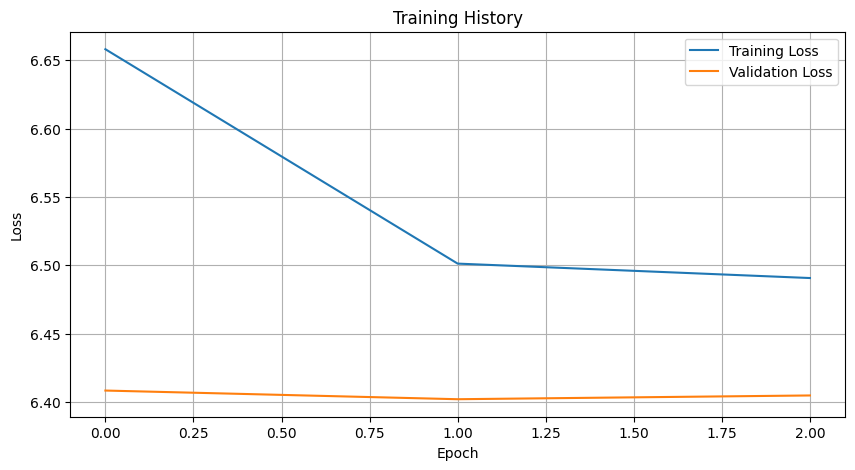


Generation Examples:

Input: Hello, how are you?
Generated: <PAD> somebody somebody actually ago world no fire as heard change open stay world world true no he's little kill that's they'll see somebody hope side fire hours very world somebody fire or uh know everybody somebody just there's see jesus rest time figure man s killed see business somebody

Input: What's your favorite movie?
Generated: <PAD> change times actually everything fire feel fire somebody see anyone mean trouble bet ain't alone figure day see house no kind wants tell live doesn't too work look change there change probably week you'll into this change hundred new somebody know see week somebody ago why alright party see

Input: Tell me a joke.
Generated: <PAD> somebody said somebody week see came want anything <UNK> beautiful pay is somebody see world fire somebody pretty part anything somebody after see world myself so week real there such haven't dr years fire myself no change change actually fire looks feel there

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch_idx, (src, src_mask, tgt) in enumerate(dataloader):
        src = src.to(device)
        tgt = tgt.to(device)
        
        # Create target input and output sequences
        tgt_input = tgt[:, :-1]  # Remove last token
        tgt_output = tgt[:, 1:]  # Remove first token
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(src, tgt_input)
        
        # Reshape outputs and targets for loss calculation
        outputs = outputs.contiguous().view(-1, outputs.size(-1))
        tgt_output = tgt_output.contiguous().view(-1)
        
        # Calculate loss
        loss = criterion(outputs, tgt_output)
        
        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for src, src_mask, tgt in dataloader:
            src = src.to(device)
            tgt = tgt.to(device)
            
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            
            outputs = model(src, tgt_input)
            outputs = outputs.contiguous().view(-1, outputs.size(-1))
            tgt_output = tgt_output.contiguous().view(-1)
            
            loss = criterion(outputs, tgt_output)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

def generate_text(model, tokenizer, input_text, max_length=50, temperature=1.0, device='cuda'):
    model.eval()
    
    # Tokenize input text
    encoded = tokenizer.encode(input_text, max_length=max_length)
    src = encoded['input_ids'].to(device)
    
    # Generate response
    with torch.no_grad():
        output_ids = model.generate(src, max_length=max_length, temperature=temperature)
    
    # Decode response
    generated_text = tokenizer.decode(output_ids[0].cpu())
    return generated_text

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, 
                num_epochs, device, tokenizer, save_path='best_model.pth'):
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        # Training phase
        train_loss = train_epoch(model, train_dataloader, criterion, optimizer, device)
        training_losses.append(train_loss)
        
        # Validation phase
        val_loss = evaluate(model, val_dataloader, criterion, device)
        validation_losses.append(val_loss)
        
        print(f"Epoch {epoch+1} Results:")
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        
        # # Save best model
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'train_loss': train_loss,
        #         'val_loss': val_loss,
        #     }, save_path)
        #     print(f"Saved best model with validation loss: {val_loss:.4f}")
        
        # Example generation
        if epoch % 2 == 0:  # Generate example every 2 epochs
            example_input = "Hello, how are you?"
            generated = generate_text(model, tokenizer, example_input, device=device)
            print("\nGeneration Example:")
            print(f"Input: {example_input}")
            print(f"Generated: {generated}")

def plot_training_history():
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train the model
num_epochs = 3
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, 
            num_epochs, device, tokenizer)

# Plot training history
plot_training_history()

# Example usage after training
test_inputs = [
    "Hello, how are you?",
    "What's your favorite movie?",
    "Tell me a joke.",
]

print("\nGeneration Examples:")
for input_text in test_inputs:
    generated = generate_text(model, tokenizer, input_text, device=device)
    print(f"\nInput: {input_text}")
    print(f"Generated: {generated}")